In [1]:
from google.colab import drive
drive.mount('/content/drive')
# replace this the path to the directory containing the code
%cd /content/drive/MyDrive/TransferED
# verify that you are in the right directory
! ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/TransferED
'“A emotion detector based on bert-multi language”的副本.ipynb'   logs
 ESD								  Main_train.ipynb
 Explore.ipynb							  test.ipynb
 final_model_freeze_finermodel					  util
 final_model_freeze_xlsr


In [2]:
#install necessary packages and set up environment

!pip install requests==2.31.0
!pip install datasets==2.19.0 huggingface-hub==0.23.0


!pip install transformers[torch] accelerate

#!pip uninstall -y huggingface-hub
#!pip install git+https://github.com/huggingface/datasets.git
#!pip install git+https://github.com/huggingface/transformers.git
#it seems to be important to install all these before setting the environment
!pip install jiwer
!pip install torchaudio
!pip install librosa
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env HF_HOME=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1


  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.23.0-py3-none-any.whl (401 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.5
    Uninstalling huggingface-hub-0.24.5:
      Successfully uninstalled huggingface-hub-0.24.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.42.4 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.23.0 which is incompatible.
  Using cached huggingface_hub-0.24.5-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.24.5-py3-none-any.whl (417 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.0
    Uninstalling huggingface-hub-0.23.0:
      Successfully uninstalled huggingface-hub-0.23.0
env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: HF_HOME=/conte

In [3]:
import importlib


import numpy as np
from sklearn.model_selection import train_test_split


import util.dataloader
importlib.reload(util.dataloader)
from util.dataloader import dfcreator, save_traindata



base_dirs = [
    "/content/drive/MyDrive/TransferED/ESD/0018",
    "/content/drive/MyDrive/TransferED/ESD/0019",
    "/content/drive/MyDrive/TransferED/ESD/0020",
    "/content/drive/MyDrive/TransferED/ESD/0017"
 #  "/content/drive/MyDrive/TransferED/ESD/0002"
]

df =  dfcreator(base_dirs)



#split into training set and test set

save_path = "/content/drive/MyDrive/TransferED/ESD"

save_traindata(save_path,df)



1750it [00:24, 72.68it/s]
1750it [00:24, 71.42it/s]
1750it [00:25, 69.83it/s]
1750it [00:24, 72.41it/s]


(6300, 3)
(700, 3)


In [4]:
from datasets import load_dataset, load_metric


# load the dataset
data_files = {
    "train": "/content/drive/MyDrive/TransferED/ESD/train.csv",
    "validation": "/content/drive/MyDrive/TransferED/ESD/test.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

A classification problem with 5 classes: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [5]:
#set up the feature extractor for audio input, there is no trainable parameters in the feature extractor

from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
model_name_or_path = "/content/drive/MyDrive/TransferED/final_model_freeze_xlsr"  #facebook/wav2vec2-large-xlsr-53 this one does not work during fine tuning?  jonatasgrosman/wav2vec2-large-xlsr-53-english  /content/drive/MyDrive/final_cs224n_colab/final_model_0531_freeze-unfreeze_1+1epoch


processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [6]:
import importlib
import util.preprocess_audio

importlib.reload(util.preprocess_audio)
from util.preprocess_audio import Audiopreprocessor

audio_preprocessor = Audiopreprocessor(target_sampling_rate=target_sampling_rate,processor=processor,label_list=label_list,input_column=input_column,output_column=output_column)

# preprocess the data

train_dataset = train_dataset.map(
    lambda examples: audio_preprocessor.preprocess_function(examples),
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    lambda examples: audio_preprocessor.preprocess_function(examples),
    batch_size=100,
    batched=True,
    num_proc=4
)

print(train_dataset)
print(eval_dataset)

Map (num_proc=4):   0%|          | 0/6300 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/700 [00:00<?, ? examples/s]

Dataset({
    features: ['name', 'path', 'emotion', 'input_values', 'attention_mask', 'labels'],
    num_rows: 6300
})
Dataset({
    features: ['name', 'path', 'emotion', 'input_values', 'attention_mask', 'labels'],
    num_rows: 700
})


In [7]:
import util.datapadder

importlib.reload(util.datapadder)

from util.datapadder import DataCollatorCTCWithPadding

# set up the data collator

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
is_regression = False

In [8]:
#define the compute metrics used in this problem

import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}


In [9]:
from transformers import AutoConfig

pooling_mode = "mean"

# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

import util.model

importlib.reload(util.model)
from util.model import Wav2Vec2ForSpeechClassification

# load the model

model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

In [10]:
#set up the trainer


from transformers import TrainingArguments, EarlyStoppingCallback, get_scheduler, TrainerCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau



training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/final_cs224n_colab",
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    gradient_accumulation_steps=1,
    eval_strategy="steps",
    num_train_epochs=1.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    save_strategy="no",
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=1e-4,
    warmup_ratio=0.08,
    save_total_limit=1,
    logging_strategy="steps",
  #  load_best_model_at_end=True,
)

In [11]:
import util.trainer

importlib.reload(util.trainer)
from util.trainer import CustomTrainer

# set up the trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
   # callbacks=[CustomCallback()],
    activate_after_steps=400
)

trainer.create_optimizer()

scheduler = ReduceLROnPlateau(trainer.optimizer, mode='min', factor=0.1, patience=2, verbose=True)

trainer.scheduler = scheduler

In [12]:
#model.freeze_feature_extractor()

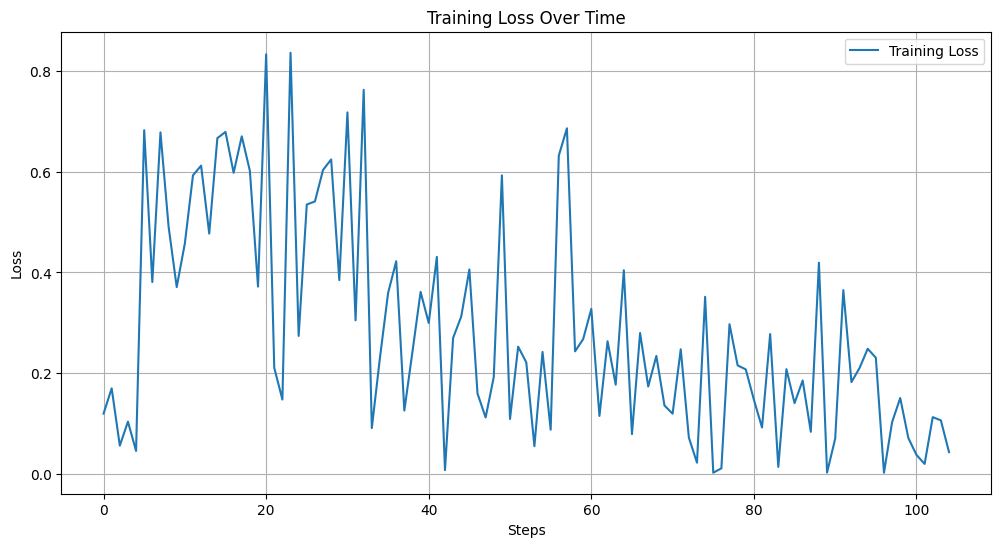

Step,Training Loss,Validation Loss,Accuracy
10,0.120000,0.083016,0.972857
20,0.170100,0.122253,0.967143
30,0.056300,0.105075,0.974286
40,0.104000,0.268882,0.940000
50,0.045900,0.482088,0.895714
60,0.682500,0.243514,0.937143
70,0.381100,0.160088,0.962857
80,0.678100,0.190216,0.957143
90,0.491100,0.320602,0.922857
100,0.371000,0.120941,0.971429


['/content/drive/MyDrive/TransferED/final_model_unfreeze_xlsr/preprocessor_config.json']

In [13]:
trainer.train()

#save the trained model

save_path = "/content/drive/MyDrive/TransferED/final_model_unfreeze_xlsr"

model.save_pretrained(save_path)
processor.save_pretrained(save_path)

In [14]:
#test on the test dataset
import torch
import os

if os.path.exists("./logs"):
    import shutil
    shutil.rmtree("./logs")
import librosa
from sklearn.metrics import classification_report
test_dataset = load_dataset("csv", data_files={"test": "/content/drive/MyDrive/TransferED/ESD/test.csv"}, delimiter="\t")["test"]
test_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model_name_or_path = "/content/drive/MyDrive/TransferED/final_model_unfreeze_xlsr"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

Generating test split: 0 examples [00:00, ? examples/s]

Device: cuda


In [15]:
# evaluation on test set
import torchaudio
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), orig_sr=sampling_rate, target_sr=processor.sampling_rate)

    batch["speech"] = speech_array
    return batch



def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

test_dataset = test_dataset.map(speech_file_to_array_fn)
result = test_dataset.map(predict, batched=True, batch_size=8)

label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

print(classification_report(y_true, y_pred, target_names=label_names))

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Parameter 'function'=<function predict at 0x7c8d85d87a30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

[1, 2, 3, 1, 0]
[1, 2, 3, 1, 0]
              precision    recall  f1-score   support

       Angry       0.99      0.99      0.99       140
       Happy       1.00      0.94      0.97       140
     Neutral       0.97      1.00      0.98       140
         Sad       1.00      0.99      0.99       140
    Surprise       0.97      1.00      0.98       140

    accuracy                           0.98       700
   macro avg       0.98      0.98      0.98       700
weighted avg       0.98      0.98      0.98       700

